# Apply Neural Networks to the Stock Market

Notebook to explore limited set of NY stock exchange data over around 40 years, as part of the Portland Data Science group (Mar 2018).
Data selected by Matt Borthwick from Yahoo! Finance.
Working with Neural Network group: Matt, John Burt, Manny, Isil, Kenny, Jhoan, Mark C.

Our goal is to predict weekly returns on 6 industry based ETFs, as well
as aggregate market performance (such as Russel3000).  We will also
be using some macroeconomic indicators as well.
This notebook currently loads the data, transforms it, and applies a
simple neural network to try predicting the next days stock prices.

The plan is to train on this data (up to Sep 2017),
validate on (Oct-Dec 2017), and test in final session on (Jan-Mar 2018).

(For more exploratory screwing around, and other attempts at time-series see PDX_finance1)

# Google Colab setup

First up however, we need to install modules to load up our google drive for storage.  (Code taken from this helpful post https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)
(Code and commands didn't look sketchy/malicious, but I didn't examine the PPA too closely either.)

This code is for execution inside a Jupyter notebook on colab.google.com.
It gives Colab access to your Google Drive in order to load/save data from within the notebook.
Colab has most popular libraries (numpy, pandas, tensorflow, matplotlib).  I'm not sure how extensive it is.

I've found opening a jupyter notebook on google drive automatically opens the Colab.

In [ ]:
#Install modules on local machine.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!echo 'past update'
!apt-get -y install -qq google-drive-ocamlfuse fuse
!echo 'installed fuse'

In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
print('past first command')
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
#Mounts google drive, and changes to that directory
!mkdir -p drive 
!google-drive-ocamlfuse drive

import os
os.chdir("drive")

#Should now be in the root of your google-drive, and now free to load/save existing files.

# Load Libraries and Data

Now to load libraries, and data.  (This is where I start my analysis
                                   on my home machine.)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# automatically reload files.
%load_ext autoreload
%autoreload 2

In [2]:
#Data compiled from Yahoo! Finance data by Matt Borthwick
df_close=pd.read_csv('data/stocks-us-adjClose.csv',index_col=0,parse_dates=True)
df_high=pd.read_csv('data/stocks-us-adjHigh.csv',index_col=0,parse_dates=True)
df_low=pd.read_csv('data/stocks-us-adjLow.csv',index_col=0,parse_dates=True)
df_vol=pd.read_csv('data/stocks-us-Volume.csv',index_col=0,parse_dates=True)
df_close.index.name='Time'
df_high.index.name='Time'
df_low.index.name='Time'
df_vol.index.name='Time'

In [4]:
df_market=pd.read_csv('data/market.csv',index_col=0,parse_dates=True)
df_etf = pd.read_csv('data/sector_ETFs.csv',index_col=0,parse_dates=True)
df_comp_info=pd.read_csv('data/Company_information.csv',encoding='latin1')

In [175]:
df_target=pd.DataFrame.join(df_market,other=df_etf,how='outer')

In [210]:
df_target

,Entire Market (^RUA),Technology (IYW),Basic Materials (IYM),Consumer Goods (IYK),Services (IYC),Healthcare (IYH),Utilities (IDU)
Date,,,,,,,
1987-09-10,178.830002,NaN,NaN,NaN,NaN,NaN,NaN
1987-09-11,181.339996,NaN,NaN,NaN,NaN,NaN,NaN
1987-09-14,181.789993,NaN,NaN,NaN,NaN,NaN,NaN
1987-09-15,179.270004,NaN,NaN,NaN,NaN,NaN,NaN
1987-09-16,177.889999,NaN,NaN,NaN,NaN,NaN,NaN
1987-09-17,177.839996,NaN,NaN,NaN,NaN,NaN,NaN
1987-09-18,177.690002,NaN,NaN,NaN,NaN,NaN,NaN
1987-09-21,175.479996,NaN,NaN,NaN,NaN,NaN,NaN
1987-09-22,179.419998,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
#got this from earlier reading in.
df_ind_col=['Date_orig', 'HOUST', 'HOUST_dt', 'UNRATENSA', 'UNRATENSA_dt', 'EMRATIO',
       'EMRATIO_dt', 'UEMPMED', 'UEMPMED_dt', 'UMCSENT', 'UMCSENT_dt',
       'USSLIND', 'USSLIND_dt', 'KCFSI', 'KCFSI_dt', 'IPMAN', 'IPMAN_dt',
       'VIXCLS', 'VIXCLS_dt', 'DGS10', 'DGS10_dt']

In [114]:
##Pieter Leffer's code for reading in indicators
import csv

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# I ran into errors importing the file because of non-ascii characters in the heading
#Here is a piece of code I got from stack overflow to fix that problem.
df_ind=[]
with open('data/Indicators_Train.csv', newline='', encoding='utf-8', errors='ignore') as f:
    reader = csv.reader(f)
    for row in reader:
        df_ind.append(row)

df_ind=pd.DataFrame(df_ind)
df_ind.columns=df_ind.iloc[0]
Column_Reference=df_ind.iloc[1].copy()
#Drop useless rows (last row is empty)
df_ind.drop([0,1],inplace=True)

#Change the formatting of the variables. Datetime to the ones for dates, integers for the ones that aren't
for i in range(0,len(df_ind.columns)):
    if i % 2 == 0:
        df_ind[df_ind.columns[i]] = pd.to_datetime(df_ind[df_ind.columns[i]], format = '%m/%d/%Y',  errors='coerce') 
    else:
        df_ind[df_ind.columns[i]] = pd.to_numeric(df_ind[df_ind.columns[i]], errors='ignore')
        
#Reset the index because we dropped rows in the DataFrame, Using the drop command to remove the old index
df_ind.reset_index(drop=True, inplace=True)

#make a time index too.
df_ind.index=pd.DatetimeIndex(df_ind['date'])


In [95]:
# #Original Attempt
# df_ind=pd.read_csv('data/Indicators_Train.csv',names=df_ind_col,skiprows=2)
# df_ind['Date']=pd.to_datetime(df_ind['Date_orig'],dayfirst=True,errors='ignore')
# df_ind.index=pd.DatetimeIndex(df_ind['Date'])
# del df_ind['Date_orig']

In [117]:
df_ind.columns

Index(['date', 'HOUST', 'HOUST_dt', 'UNRATENSA', 'UNRATENSA_dt', 'EMRATIO',
       'EMRATIO_dt', 'UEMPMED', 'UEMPMED_dt', 'UMCSENT', 'UMCSENT_dt',
       'USSLIND', 'USSLIND_dt', 'KCFSI', 'KCFSI_dt', 'IPMAN', 'IPMAN_dt',
       'VIXCLS', 'VIXCLS_dt', 'DGS10', 'DGS10_dt'],
      dtype='object', name=0)

In [137]:
Column_Reference

0
date                                                                        desc
HOUST           Housing Starts: Total: New Privately Owned Housing Units Started
HOUST_dt                                                                        
UNRATENSA                                         Civilian Unemployment Rate NSA
UNRATENSA_dt                                                                    
EMRATIO                                     Civilian Employment-Population Ratio
EMRATIO_dt                                                                      
UEMPMED                                          Median Duration of Unemployment
UEMPMED_dt                                                                      
UMCSENT                               University of Michigan: Consumer Sentiment
UMCSENT_dt                                                                      
USSLIND                                          Leading Index For United States
USSLIND_dt                

In [128]:
sl

slice(1, -2, 2)

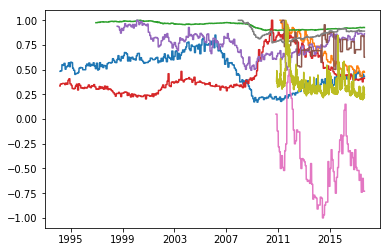

In [211]:
#Plots the scaled values of the economic indictors.
sl=slice(1,-2,2)
df_ind_scale=df_ind.iloc[:,sl].abs().max()
cutoff=int(len(df_ind)/2)
plt.plot(df_ind.iloc[cutoff:,sl]/df_ind_scale)
plt.show()

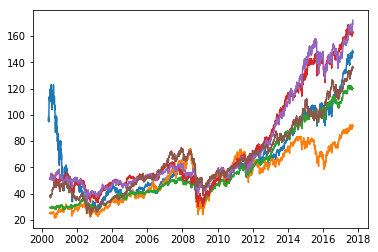

In [212]:
plt.plot(df_etf)
plt.show()

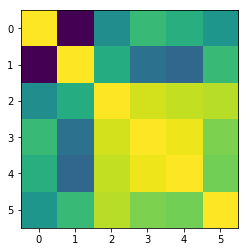

In [213]:
etf_corr=df_etf.corr()
plt.figure()
plt.imshow(etf_corr)
plt.show()

In [26]:
#Make a combined Panel (which is apparently redundant, and multiindex is preferred)
panel=pd.Panel({'close':df_close,'low':df_low,'high':df_high,'vol':df_vol})

In [168]:
#panel.loc[:,'2016','ED']
df_etf.tail()

            Technology (IYW)  Basic Materials (IYM)  Consumer Goods (IYK)  \
Date                                                                        
2017-09-01        149.100861              92.463394            120.529594   
2017-09-05        147.656967              91.263222            120.192558   
2017-09-06        147.955704              91.560776            120.400726   
2017-09-07        148.423721              91.699638            120.509766   
2017-09-08        147.039566              91.540939            120.301598   

            Services (IYC)  Healthcare (IYH)  Utilities (IDU)  
Date                                                           
2017-09-01      163.167038        169.770630       135.633087  
2017-09-05      162.589981        168.935532       135.900024  
2017-09-06      163.565002        169.720917       135.207962  
2017-09-07      162.709366        171.331421       136.246048  
2017-09-08      162.012939        172.077026       136.928207  

In [215]:
Nstocks=df.shape[1]-np.isnan(df).sum(axis=1)

NameError: name 'df' is not defined

In [214]:
#Plot number of stocks

plt.figure()
plt.plot(Nstocks['2010':])
plt.show()


NameError: name 'Nstocks' is not defined

In [ ]:
Looking at the number of NA values (summed across columns) suggests that
there are missing values in these stocks.

Could set all NA to zero, then apply linear interpolation to handle isolated
missing days.

In [162]:
panel['vol'].columns[702]

'ACG'

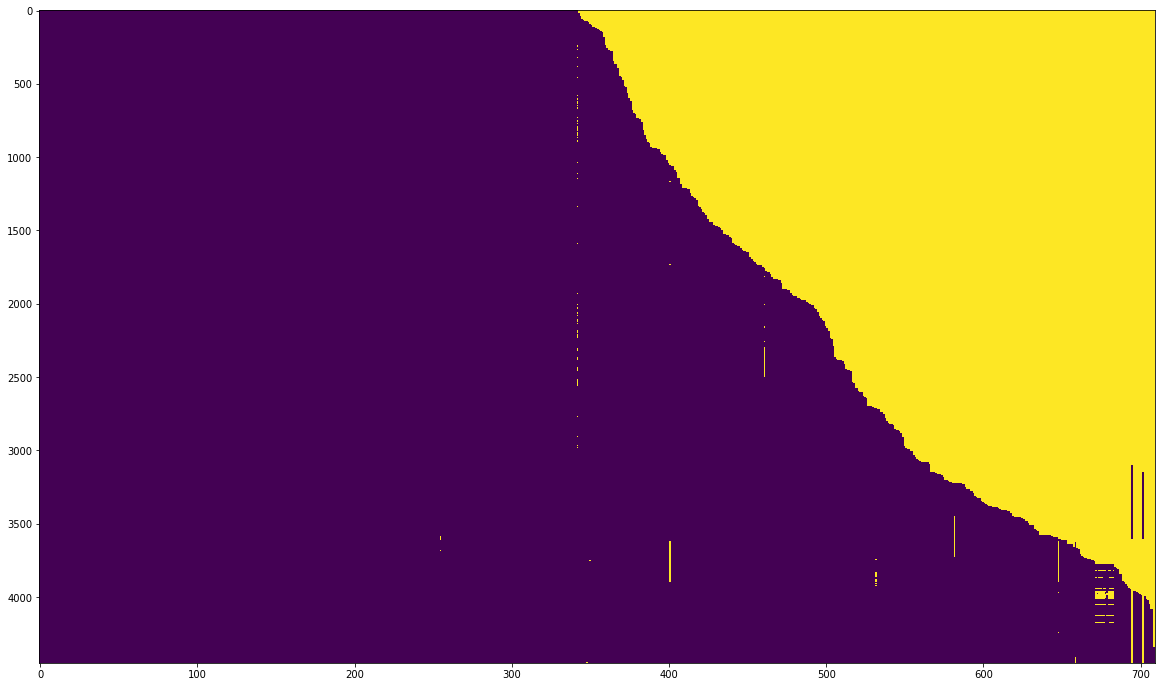

In [217]:
#Plot pattern of NA values.  Weird stripes?
plt.figure(figsize=(20,12))
col=panel['close'].columns[0:]
plt.imshow(np.isnan(panel['close','2000':,col]),aspect='auto')
plt.show()

In [30]:
plt.figure()
col=panel['vol'].columns[702]
plt.plot(panel['close','2000':,col])
plt.show()

# Neural Network

This model is just a test based purely on the stock data.
The network uses a multi-layer RNN, with two hidden layers at input/output.  They use leaky ReLU activation.
The model currently plays with 100 stocks from 2002-2006.

This uses a model I've cobbled together in Tensorflow.
The OO structure is borrowed from the online problem sets
from CS224 on NLP offered in 2017 at Stanford.
The NN is borrowed from A. Geron "Hands on Machine Learning with Scikit-Learn and Tensorflow", which I've found to be the best
overall introduction, and has a good mix of background, and code.
(There is also an associated Github account with code).

The Tensorflow docs were pretty hard reading, and there seem to be lots
of tricks that only practitioners on StackOverflow are aware of.  (But the tutorials are pretty readable.)


In [3]:
import tensorflow as tf
from recurrent_network import recurrent_NN

# Data Transformation

For the initial testing, I'm just building a model based on the 100 oldest stocks (or whichever come first), and looking at 2002-2006.
Why then?  Because it looks relatively well behaved.
The model is trained on the first half of the data, and we then run the
network on the whole data set.

I'm currently just taking the base-10 log of the data, and scaling each
stock to lie with [-1,1].  I found differencing the data lead to
pretty crappy results (then again, these are also pretty crap results).

So there's some choices to be played with here:
- scaling: variance vs max/min
- differencing?

In [40]:
Nstocks=200
Xsub=panel.loc['close','1999':'2006'].iloc[:,:Nstocks].values

def scale_clean_data(X):
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X[np.isnan(X)]=0
    #take differences of logs. (shift zero to avoid NANs)
    #Xsub2 = np.diff(np.log10(Xsub+1E-12),axis=0)
    X = np.log10(Xsub+1E-16)

    X_max = np.max(X,axis=0)
    X_min = np.min(X,axis=0)

    #Choice of scaling here: max/min vs variance?
    #I think variance makes more sense if differencing.
    rng = 0.5*(X_max-X_min)
    avg = 0.5*(X_max+X_min)
    Xscaled= (X-avg)/rng
    return Xscaled,rng,avg

Xsub2,rng,avg=scale_clean_data(Xsub)

#split 3/4 as training, 1/4 as test
N=len(Xsub2)
Nc=int(3*N/4)
#make training/test splits
Xtrain = Xsub2[:Nc]
ytrain = Xsub2[1:Nc+1] #tomorrow's return.

Xtest=Xsub2[Nc:-1]
ytest=Xsub2[Nc+2:]

In [22]:
#check scaling
plt.figure()
plt.plot(Xtrain[:,0:5])
plt.plot(ytrain[:,0:5])
plt.show()

# Fitting RNN

In [11]:
#define network.
#Note a lot of network parameters are defined in __init__ in "recurrent_network.py".
#A more robust structure would pass a config dict or something like that.
RNN=recurrent_NN(60,Nstocks,100,Nstocks,'LSTM')

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 100) dtype=float32>))
Tensor("strided_slice:0", shape=(2, ?, 200), dtype=float32)


In [96]:
#Rebuild the tensorflow graph.
RNN.build()
#Actually train the graph on first half of data.
#Give all of the data to this subroutine, where it selects
# the inputs and target data in get_random_batch


RNN.train_graph(Xtrain,Xtrain,save_name='tf_models/rnn_test')
#Note the tiny, tiny errors.  Probably badly overfitting.
#Need to fix the dropout so it's only on in training.

iter #100. Current MSE:0.09078984707593918
Total Time taken:62.78987383842468




KeyboardInterrupt: 

In [93]:
%pdb off

Automatic pdb calling has been turned OFF


In [97]:
#Predict on all of the data.
#This loads up a previous model.
RNN_pred=RNN.predict_all('tf_models/rnn_test',200,Xsub2,reset=True)

INFO:tensorflow:Restoring parameters from tf_models/rnn_test-200
0 100


ValueError: could not broadcast input array from shape (2,100,200) into shape (100,200)

In [11]:
def plot_pred(X,pred,indx_range):
    """Plots a particular stock and the prediction"""

    plt.figure()
    plt.subplot(121)
    plt.plot(X[:,indx_range])
    plt.plot(pred[:,indx_range])
    plt.plot([len(X)/2]*2,[-1,1],'k-')
    plt.legend(['Actual','Forecast'])
    plt.title('Raw')

    plt.subplot(122)
    plt.plot(np.cumsum(X[:,indx_range],axis=0))
    plt.plot(np.cumsum(pred[:,indx_range],axis=0))
    plt.legend(['Actual','Forecast'])    
    plt.title('Cumulative')

    plt.show()
    

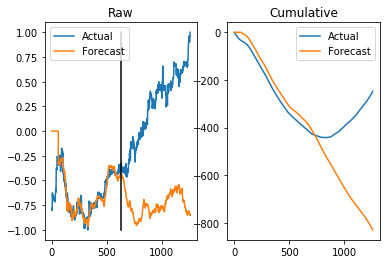

In [17]:
#Could make predicted results a time series for nicer formating, and dates.
#Plot cumulative for cases when we've also differenced.
plot_pred(Xsub2,RNN_pred,50)

This RNN forecast is also WAY worse than a persistence forecast (tomorrow's price is the same as todays).
Big question: why is the price wandering away? Even if the model is fixed (weights unchanged), surely it should take the recent past (which the model uses to forecast tomorrow's demand) into account.  

Note the effect of further smoothing, which suggests a clearer trend, that might be easier to model.
That suggests the convolutional networks may be useful,
perhaps with running averages to smooth the data.  Forecasting on a week timescale might allevative some of that too?

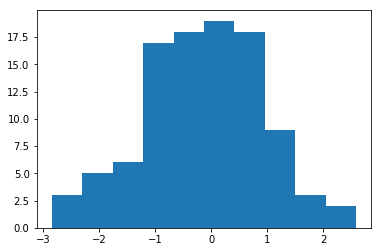

In [13]:
#Let's look at the differences between the predicted and actual
#results at the end of the period.
pred_diff=RNN_pred[-1]-Xsub2[-1]
plt.hist(pred_diff)
plt.show()

In [15]:
(np.mean(pred_diff),np.std(pred_diff))

(-0.1433746024133806, 1.0660086500156463)

In [104]:
#Let's now see how much the predictions vary (across all stocks) at the end of training, 20 trading days after that,
# and at the end of the period, a year or two out.

#Note that these predictions use the data from those periods, but the model is not being updated.

def plot_err_hist(target,pred,Nc):
    '''plot_err_hist

    Makes histograms of the errors between the target and prediction
    at multiple time scales aroud the tend of the training period.
    '''
    
    Nc = int(len(Xsub2)/2)
    plt.figure(figsize=(10,6))

    plt.subplot(141)
    pred_diff=pred[Nc-20]-target[Nc-20]
    plt.title('End of training - 20 days')
    plt.hist(pred_diff)

    plt.subplot(142)
    pred_diff=pred[Nc]-target[Nc]
    plt.title('End of training')
    plt.hist(pred_diff)

    plt.subplot(143)
    pred_diff=pred[Nc+20]-target[Nc+20]
    plt.title('End of training+20 days')
    plt.hist(pred_diff)

    plt.subplot(144)
    pred_diff=pred[-1]-target[-1]
    plt.hist(pred_diff)
    plt.title('End of test')
    plt.xlabel('Forecast Residuals')
    plt.show()



The final graph is worst, it is also trying to predict many years ahead, based on essentially short-term info.
Probably could describe build up of cumulative errors as a random walk?
Would guess errors grows as sqrt(T), so the variance of this distribution grows as T.



# Keras Network

Let's build a similar recurrent network in Keras (just using the adjusted close for now).

In [23]:
#Borrowing some from Keras docs, and "https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/"
import keras  
from keras.models import Sequential 
from keras.layers import Dense, RNN, LSTM, StackedRNNCells
from keras.losses import mean_squared_error, mean_absolute_error
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import CustomObjectScope

Using TensorFlow backend.


In [179]:
Nstock=100
Nfeature=1
Ninput=Nstock*Nfeature
Ntime=10
Nahead=5
Nhidden=50
Nepoch=100
Nbatch=100
Nprint=20
Noutput=Nstock*Nfeature

In [189]:
Xsub=panel.loc['close','1995':'2000'].iloc[:,:Nstock].values

def clean_data_maxmin(X):
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X[np.isnan(X)]=0
    #take differences of logs. (shift zero to avoid NANs)
    #Xsub2 = np.diff(np.log10(Xsub+1E-12),axis=0)
    X = np.log10(Xsub+1E-16)

    X_max = np.max(X,axis=0)
    X_min = np.min(X,axis=0)

    #Choice of scaling here: max/min vs variance?
    #I think variance makes more sense if differencing.
    rng = 0.5*(X_max-X_min)
    avg = 0.5*(X_max+X_min)
    Xscaled= (X-avg)/rng
    return Xscaled,rng,avg

def clean_data_diff_var(X):
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X[np.isnan(X)]=0
    #take differences of logs. (shift zero to avoid NANs)
    X = np.diff(np.log10(X+1E-12),axis=0)

    X_std = np.std(X,axis=0)
    X_mean = np.mean(X,axis=0)

    Xscaled= (X-X_mean)/X_std
    return Xscaled,X_mean,X_std

differencing=False
if (differencing):
   Xsub_scale,rng,avg=clean_data_diff_var(Xsub)
else:
    Xsub_scale,rng,avg=clean_data_maxmin(Xsub)

#split 3/4 as training, 1/4 as test
N=len(Xsub_scale)
Nc=int(3*N/4)
#make training/test splits
Xtrain = Xsub_scale[:Nc]
ytrain = Xsub_scale[Nahead:Nc+Nahead] #Stock price in time Nahead

Xtest=Xsub_scale[Nc:-Nahead]
ytest=Xsub_scale[Nc+Nahead:]
ytot=Xsub_scale[Nahead:]

I had hoped Keras would automatically take care of random temporal batching like this, but unfortunately it does not.
So, this routine which randomly selects a batch of indices to start fitting at.  

In [184]:
#note: this relies on looking up global parameters (blech)
def get_random_batch(Nbatch,X,y):
    #starting indices
    ind=np.arange(len(X[:,0])-Ntime-Nahead)
    rand_ind=np.random.choice(ind,Nbatch,replace=False)
    Xb=np.zeros((Nbatch,Ntime,Ninput))
    yb=np.zeros((Nbatch,Noutput))    
    for i in range(Nbatch):
        Xb[i]=X[rand_ind[i]:rand_ind[i]+Ntime,:]
        yb[i]=y[rand_ind[i]+Ntime+Nahead-1,:]
    return Xb,yb

## Making the Network

The following makes a 4 layer network - a dense layer at input, followed by two recurrent layers (using a LSTM for longer memory),
and a final dense layer to map from the hidden units to the final outputs.
It uses "leaky ReLU" units, which are suited to long sequences since the gradients dont explode, or go to zero.
The Adam optimizer is basically a fancy version of gradient descent (with a momentum, scaling based on previous updates, and learning rate scheduling)

In [202]:
#make a Keras model two layer LSTM, with dense input/outputs
def make_deep_RNN(Nhidden,Ntime,Ninput):
    keras.backend.clear_session()
    model=Sequential()
    model.add(Dense(units=Nhidden, activation=None, input_shape=(Ntime,Ninput))) #linear mapping at input
    #first LSTM layer
    model.add(LSTM(units=Nhidden,activation='linear',
               dropout=0.25,return_sequences=True))
               #add extra activation layer afterwards
    act = keras.layers.advanced_activations.LeakyReLU(alpha=0.1)               
    model.add(act)
    #second LSTM layer
    model.add(LSTM(units=Nhidden,activation='linear',
                   dropout=0.25,return_sequences=True))
    model.add(act)
    #third LSTM layer
    model.add(LSTM(units=Nhidden,activation='linear', dropout=0.25,return_sequences=False))
    model.add(act)               
    #final linear mapping at output
    model.add(Dense(units=Noutput,activation='linear',input_shape=(Ntime,Nhidden))) #output layer
    model.compile(optimizer='adam',loss=mean_squared_error)
    return model

def train_model(model,Xtrain,ytrain,Nbatch,Nepoch):
    for i in range(Nepoch+1):
        Xb,yb=get_random_batch(Nbatch,Xtrain,ytrain)
        if (i)%Nprint==0:
            model.fit(Xb,yb, epochs=1,batch_size=Nbatch,verbose=1)
        else:
            model.fit(Xb,yb, epochs=1,batch_size=Nbatch,verbose=0)
        model.reset_states()
    return model

def predict_from_model(model,X,Ntime,Ninput,Noutput,Nbatch):
    #Predict on whole of this subset (both "training" and "testing")
    Nf = len(X)-Ntime
    ypred_tot=np.zeros((Nf,Noutput))
    i0=Nahead
    i1=i0+Nbatch
    #split whole time sequence into sequential batches.
    while (i1 < Nf):
        X0=np.zeros((Nbatch,Ntime,Ninput))
        for i in range(Nbatch):
            X0[i]=X[i0+i:i0+i+Ntime]
        ypred_tot[i0:i1]=model.predict(X0,batch_size=Nbatch)
        model.reset_states()    
        i0=i1
        i1+=Nbatch
    #predict on the remainder
    Nrem=Nf-i0
    X0=np.zeros((Nrem,Ntime,Ninput))
    for i in range(Nrem):
        X0[i]=X[i0+i:i0+i+Ntime]

    ypred_tot[-Nrem:]=model.predict(X0,batch_size=Nbatch)
    model.reset_states()
    return ypred_tot


In [197]:
model=make_deep_RNN(Nhidden,Ntime,Ninput)
model=train_model(model,Xtrain,ytrain,Nbatch,Nepoch)


Epoch 1/1
100/100 [==============================] - 0s 693us/step - loss: 0.0364
Epoch 1/1
100/100 [==============================] - 0s 734us/step - loss: 0.0418
Epoch 1/1
100/100 [==============================] - 0s 726us/step - loss: 0.0559
Epoch 1/1
100/100 [==============================] - 0s 711us/step - loss: 0.0922
Epoch 1/1
100/100 [==============================] - 3s 29ms/step - loss: 0.2788
Epoch 1/1


## Training the Network

Now run in minibatches.  The "if" statement means we only see the output every 50 iterations.
The "reset_states()" call should reset the internal state of the model.
Note that the reported loss is the loss (MSE) on the current batch.  

## Predicting the whole sequence

This runs the network on the whole subset of data we've pulled out from 2000 to 2008.  This checks performance on both the training data,
as well as the holdout data.  As we'll see, the performance drops precipitously once training ends.   

In [203]:
ypred=predict_from_model(model,Xsub_scale,Ntime,Ninput,Noutput,Nbatch)

In [193]:
def plot_predictions(X,ytarget,ypred,Nplot_start,skip):
    Nplot_end=Nplot_start+skip
    plt.figure()
    legend_list=[]
    #plot training data
    for i in range(Nplot_start,Nplot_end):
        if (differencing):
            plt.plot(np.cumsum(X[:,i],axis=0))
        else:
            plt.plot(Xsub_scale[:,i])    
        legend_list.append(df_close.columns[i])
    #plot prediction    
    for i in range(Nplot_start,Nplot_end):
        if (differencing):
            plt.plot(np.cumsum(ypred[:,i],axis=0),'--')
        else:
            plt.plot(ypred[:,i],'--')    
        legend_list.append(df_close.columns[i]+'-pred')
    #plot actual    
    for i in range(Nplot_start,Nplot_end):
        if (differencing):
            plt.plot(np.cumsum(ytarget[:,i],axis=0),'--')
        else:
            plt.plot(ypred[:,i],'-.')    
        legend_list.append(df_close.columns[i]+'-target')
    plt.plot([Nc,Nc],[-1,1],'k')    
    plt.legend(legend_list,bbox_to_anchor=(1,1))
    plt.show()

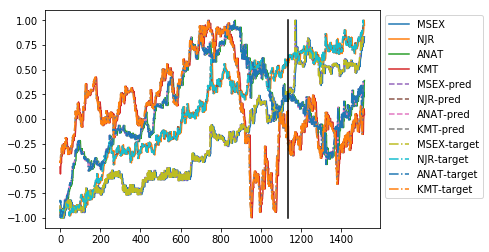

In [218]:
plot_predictions(Xsub_scale,ypred,ytot,60,4)

In [229]:
[ypred[0:20,2],ytot[0:20,2]]

[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.80532902, -0.80370259, -0.80109221, -0.799052  , -0.79478121, -0.79112494,
        -0.78917456, -0.78768802, -0.78638172, -0.79266095, -0.79890746, -0.80647117, -0.81442469, -0.81215906, -0.80523992]),
 array([-0.96060116, -0.98301826, -1.        , -0.96618126, -0.96618126, -0.93843536, -0.90023526, -0.90023526, -0.87339482, -0.87873329, -0.87339482,
        -0.84691504, -0.86276029, -0.87339482, -0.91107355, -0.94395322, -0.93293252, -0.91107355, -0.89483668, -0.85218241])]

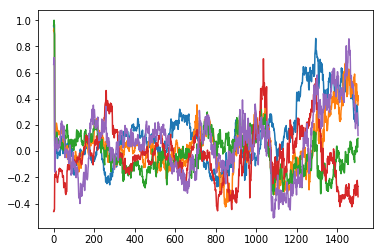

In [228]:
#plot errors
plt.figure()
Nplot_start=0
Nplot_end=5
legend_list=[];
for i in range(Nplot_start,Nplot_end):
    plt.plot(ypred[:,i]-ytot[:-Nahead,i])
    legend_list.append(df_close.columns[i])
plt.show()

In [257]:
plot_err_hist(Xsub_scale,ypred_tot,Nc)

So, the model is doing terribly.  I thought it would at least track the correct price (and get the directions wrong).
As is, the resulting predictions are wandering far away from the actual price, even when given the correct price data.

Does this make sense?  Under one point of view, these variables are all random walks.  Even if they are correlated,
then, we can find some independent variables which are also given by random walks.  We're fitting a neural network with
memory, and training it to fit this noise.  And when fed new noise, the results are wandering away from the prediction.


# Testing Fitting a Random Walk

Let's apply the same network architecture for fitting a single random walk.  Then, let's 